In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.decomposition import PCA
import json
from sklearn.cluster import DBSCAN

In [2]:
#features used for each cluster

iv_list=['duels', 
         'duelsWon',
         'defensiveDuels',
         'defensiveDuelsWon', 
         'passes', 
         'successfulPasses', 
         'forwardPasses', 
         'succuessfulForwardPasses', 
         'aerialDuels', 
         'aerialDuelsWon', 
         'defensiveActions', 
         'successfulDefensiveAction', 
         'recoveries',
         'opponentHalfRecoveries',
         'losses', 
         'ownHalfLosses',
         'dangerousOwnHalfLosses',
         'looseBallDuels',
         'looseBallDuelsWon',
         'slidingTackles',
         'successfulSlidingTackles',
         'progressiveRun'
         ]
lb_list=['duels', 
         'duelsWon',
         'defensiveDuels',
         'defensiveDuelsWon', 
         'passes', 
         'successfulPasses', 
         'forwardPasses', 
         'successfulForwardPasses', 
         'crosses', 
         'successfulCrosses',
         'aerialDuels', 
         'aerialDuelsWon', 
         'defensiveActions', 
         'successfulDefensiveAction', 
         'recoveries',
         'opponentHalfRecoveries',
         'losses', 
         'ownHalfLosses',
         'dangerousOwnHalfLosses',
         'looseBallDuels',
         'looseBallDuelsWon',
         'slidingTackles',
         'successfulSlidingTackles',
         'interceptions',
         'progressiveRun',
         'xgAssist'
         ]
midfield_list= ['pressingDuels', 
                'recoveries',
                'opponentHalfRecoveries',
                'defensiveDuels',
                'defensiveDuelsWon', 
                'interceptions',
                'xgAssist',
                'passes',
                'successfulPasses',
                'receivedPass',
                'throughPasses',
                'successfulThroughPasses',
                'passesToFinalThird',
                'forwardPasses',
                'successfulForwardPasses',
                'progressiveRun',
                'longPasses',
                'successfulLongPasses',
                'losses',
                'ownHalfLosses',
                'keyPasses',
                'xgShot',
                'touchInBox',
                'offensiveDuels'
]

wing_list=[
          'xgShot',
          'shots',
          'shotsOnTarget',
          'shotAssists',
          'touchInBox',
          'xgAssist',
          'receivedPass',
          'successfulPasses',
          'keyPasses',
          'pressingDuels', 
          'crosses',
          'dribbles',
          'progressiveRun',
          'offensiveDuels',
          'offensiveDuelsWon'

]

striker_list=[
          'xgShot',
          'shots',
          'shotsOnTarget',
          'shotAssists',
          'touchInBox',
          'xgAssist',
          'receivedPass',
          'keyPasses',
          'progressivePasses',
          'losses', 
          'ownHalfLosses',
          'recoveries',
          'opponentHalfRecoveries',
          'goals'
    
]
offmid_list=[   'pressingDuels', 
                'looseBallDuels',
                'looseBallDuelsWon',
                'recoveries',
                'opponentHalfRecoveries',
                'interceptions',
                'passes',
                'successfulPasses',
                'receivedPass',
                'passesToFinalThird',
                'forwardPasses',
                'successfulForwardPasses',
                'progressiveRun',
                'keyPasses',
                'xgAssist',
                'xgShot',
                'touchInBox',
                'offensiveDuels',
                'shotsOnTarget'
]

defmid_list=[   'pressingDuels', 
                'recoveries',
                'opponentHalfRecoveries',
                'defensiveDuels',
                'defensiveDuelsWon', 
                'interceptions',
                'passes',
                'successfulPasses',
                'receivedPass',
                'throughPasses',
                'successfulThroughPasses',
                'passesToFinalThird',
                'forwardPasses',
                'successfulForwardPasses',
                'progressiveRun',
                'longPasses',
                'successfulLongPasses',
                'losses',
                'ownHalfLosses',
                'keyPasses',
                'xgAssist'
]


In [3]:
#negative features are multiplied by -1 for the convention

loss_list= [
    'total.losses',
    'total.ownHalfLosses',
    'total.dangerousOwnHalfLosses'
]

In [197]:
pd.set_option('display.max_columns', 5000)

In [5]:
#function returns the player given the wyscout match and player id
def get_player(playerid, matchId):

    path='data/events/'+str(matchId)+'.json'
    with open(path, 'r', encoding='utf-8') as f:
        rd = f.read()
    rd=rd[28:-2]
    obj = json.loads(rd)
    dfw = pd.json_normalize(obj)
    dfw=dfw[dfw['player.id']==playerid]
    return dfw['player.name'].iloc[0]

In [6]:
#function to remove the outliers from the data, l and u are upper resp. lower bound of the data to keep
def remove_outliers(data, l, u,threshold=1.5):
    num_dimensions = data.shape[1]
    mask = np.ones(data.shape[0], dtype=bool)

    for dim in range(num_dimensions):
        q1 = np.percentile(data[:, dim], l)
        q3 = np.percentile(data[:, dim], u)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        mask = np.logical_and(mask, (data[:, dim] >= lower_bound) & (data[:, dim] <= upper_bound))

    cleaned_data = data[mask]
    return cleaned_data

In [7]:
#turns the mean of each cluster into a dataframe
def centroiddf(resdf, meanarray):
    df = pd.DataFrame(columns=resdf.columns)
    for i in range(meanarray.shape[0]):
        df.loc[i]=meanarray[i]

    return df

In [8]:
#drops all irrelevant features and removes the outliers. data is prepared and normalized shifted to use cosine similarity
def preprocessarray(attr_list, file, rem, l, u):
    cluster_attr=[]
    for word in attr_list:
        cluster_attr = cluster_attr+['total.'+word]
    df=pd.read_csv(file)
    dfcalc = df[df.columns[df.columns.isin(cluster_attr)]]
    for w in loss_list:
        if(w in cluster_attr):
            df[w]*=-1
            dfcalc[w]*=-1
    arr=dfcalc.to_numpy()
    print('total points')
    print(arr.shape)
    print()
    if(rem):
        arr=remove_outliers(arr, l, u)
    normarr=arr.copy()
    norms=np.linalg.norm(normarr, axis=1, keepdims=True)
    normarr=normarr/norms
    m=abs(normarr.min())+0.5
    print(m)
    print('after cleanup:', arr.shape)
    print(normarr.shape)
    return normarr+m, arr, df, dfcalc

In [ ]:
pd.read_csv(filename)

In [9]:
filename='norm_stats/normalized_wingerstats.csv'
figurename='wi2v2.jpg'
poslist=wing_list

remove=True
savefilename='wi2v2clustering.csv'
elbowplot=True
n=3

processarray, ogarray, df, dfcalc=preprocessarray(poslist, filename, remove, 20, 80)

total points
(1668, 15)

1.1605671712503747
after cleanup: (1365, 15)
(1365, 15)


c:\Users\Rui\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


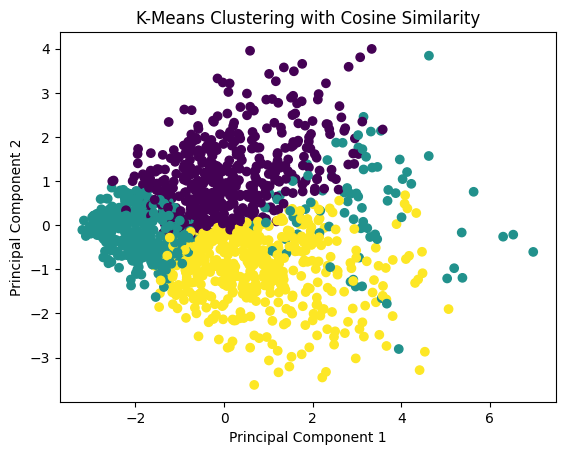

In [13]:
ass=clustering(n, figurename, False, processarray, ogarray)

In [14]:
cluster_lists = [[] for _ in range(n)]
for i, label in enumerate(ass):
    cluster_lists[label].append(i)

meanarr=ogarray.copy()

columnarray=np.empty((0,ogarray.shape[1]))
stdarray=np.empty((0,ogarray.shape[1]))
for i in range(n):

    selected_rows = meanarr[cluster_lists[i], :]
    print('number of points in cluster',i)
    print(len(cluster_lists[i]))

    # Calculate the mean and std every cluster
    column_means = np.mean(selected_rows,axis=0)
    column_std = np.std(selected_rows,axis=0)
    mean_reshaped= column_means.reshape(1,-1)
    std_reshaped = column_std.reshape(1,-1)
    columnarray=np.concatenate((columnarray,mean_reshaped), axis=0)
    stdarray=np.concatenate((stdarray,std_reshaped),axis=0)
    print("Mean of cluster:",i)
    print (column_means)
    print(column_std)

number of points in cluster 0
449
Mean of cluster: 0
[-0.08980615 -0.57577094 -0.53544266  0.29775654 -0.02043609  0.09676627
 -0.53579264 -0.10615721  0.13049361 -0.12967155  0.03803386  0.30290219
 -0.07823476 -0.15514497 -0.07553931]
[0.7534711  0.54659421 0.49296148 0.85603108 0.78125581 0.83939898
 0.44237308 0.86717007 0.78721269 0.6052281  0.75357308 0.82322398
 0.74014006 0.72841386 0.78559068]
number of points in cluster 1
432
Mean of cluster: 1
[-0.51098504 -0.48844276 -0.47830151 -0.53196497 -0.39113756 -0.30673564
 -0.45004905  0.12057544 -0.37932057 -0.39534297 -0.34487825 -0.54064865
 -0.46968038 -0.37261438 -0.4038958 ]
[0.74816797 0.80461324 0.78753407 0.72687553 0.67323545 0.62305485
 0.79668333 0.92787549 0.70179206 0.45993889 0.57064384 0.70693077
 0.73895778 0.76071467 0.61062506]
number of points in cluster 2
484
Mean of cluster: 2
[-0.02185916  0.64963636  0.50546527 -0.2933617  -0.05480733 -0.37942496
  0.48452239 -0.09501321 -0.36147087 -0.17349442 -0.38386109 -

In [47]:
meandf=centroiddf(dfcalc,columnarray)
stddf=centroiddf(dfcalc, stdarray)
meandf.to_csv('mean_'+savefilename)
stddf.to_csv('std_'+savefilename)

In [ ]:
pd.read_csv('mean_std/mean_strikerclustering.csv')

In [ ]:
meandf

In [ ]:
stddf

c:\Users\Rui\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


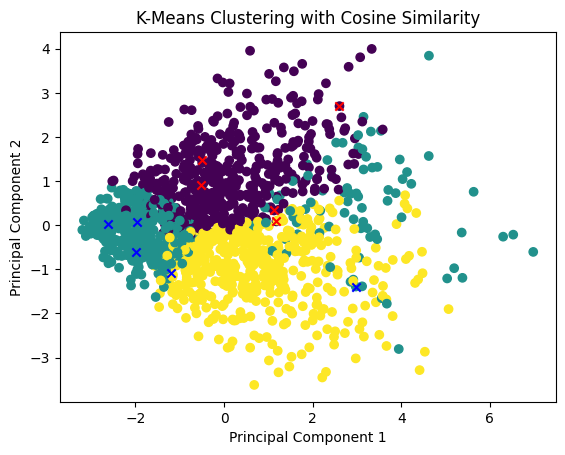

In [49]:
#illustrating the cluster assignments

#0=red, 1=blue, 2=green, 3=black, 4= cyan, 5=white
cosine_distances = pairwise_distances(processarray, metric='cosine')
kmeans= KMeans(n_clusters=n, init="k-means++", random_state=42, max_iter=100000)
kmeans.fit(cosine_distances)
# Get the cluster assignments
cluster_assignments = kmeans.labels_

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(ogarray)
cluster_lists = [[] for _ in range(n)]
for i, label in enumerate(cluster_assignments):
    cluster_lists[label].append(i)
# Plot the results
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_assignments, cmap='viridis')

for a in range(5):
    pointlist= cluster_lists[0]
    point=pointlist[a]
    plt.scatter(data_2d[point, 0], data_2d[point, 1], marker='x', color='red')

for a in range(5):
    pointlist= cluster_lists[1]
    point=pointlist[a]
    plt.scatter(data_2d[point, 0], data_2d[point, 1], marker='x', color='blue')

'''
for a in range(5):
    pointlist= cluster_lists[2]
    point=pointlist[a]
    plt.scatter(data_2d[point, 0], data_2d[point, 1], marker='x', color='green')
for a in range(5):
    pointlist= cluster_lists[3]
    point=pointlist[a]
    plt.scatter(data_2d[point, 0], data_2d[point, 1], marker='x', color='cyan')
for a in range(5):
    pointlist= cluster_lists[2]
    point=pointlist[a]
    plt.scatter(data_2d[point, 0], data_2d[point, 1], marker='x', color='green')
'''
name='withcrosses_'+figurename
plt.title('K-Means Clustering with Cosine Similarity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig(name)
plt.show()

In [11]:
#clustering function, using n clusters. elbow is a boolean for printing the elbow plot. arr is a numpy array with the player data and
#normarr is the modified data array, where all performance vectors are divded through their norm.
def clustering(n, figurename, elbow, normarr, arr):
    if(elbow):
        k_values = range(1, 10)

        # Calculate and store the inertia for each k
        inertia_values = []
        for k in k_values:
            kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, random_state=42)
            cosine_distances = pairwise_distances(normarr, metric='cosine')
            kmeans.fit(cosine_distances)
            inertia_values.append(kmeans.inertia_)

        # Plot the elbow curve
        plt.plot(k_values, inertia_values, marker='o')
        plt.title('Loss per cluster')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.savefig('elbow'+figurename)
        plt.show()
        return []
    else:
        cosine_distances = pairwise_distances(normarr, metric='cosine')
        kmeans= KMeans(n_clusters=n, init="k-means++", random_state=42, max_iter=100000)
        kmeans.fit(cosine_distances)
        # Get the cluster assignments
        cluster_assignments = kmeans.labels_

        # Reduce dimensionality using PCA
        pca = PCA(n_components=2)
        data_2d = pca.fit_transform(arr)
        # Plot the results
        plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_assignments, cmap='viridis')
        #plt.scatter(data_2d[0, 0], data_2d[0, 1], marker='x', color='red', label='purple')
        #plt.scatter(data_2d[26, 0], data_2d[26, 1], marker='x', color='red', label='green')
        #plt.scatter(data_2d[11, 0], data_2d[11, 1], marker='x', color='red', label='yellow')
        #plt.scatter(data_2d[min_ind, 0], data_2d[min_ind, 1], marker='x', color='red', label='Min PC1')
        plt.title('K-Means Clustering with Cosine Similarity')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.savefig(figurename)
        plt.show()
        return kmeans.labels_